# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernible landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [1]:
# !pip install split-folders torchsummary optim

In [2]:
import os
import numpy as np
import torch
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
from torchvision import datasets, models, transforms
import torchvision.models as models
from torch.profiler import profile, record_function, ProfilerActivity
import matplotlib.pyplot as plt
from time import time

import torch.nn as nn
import torch.nn.functional as F

import splitfolders

from torchsummary import summary
from torch.optim.lr_scheduler import StepLR

%matplotlib inline

In [3]:
# !conda install matplotlib

In [4]:
# data_dir = 'landmark_images/'
# train_dir = os.path.join(data_dir, 'train/')
# test_dir = os.path.join(data_dir, 'test/')
# data_dir = '/data/'
# train_dir = os.path.join(data_dir, 'landmark_images/train/')
# test_dir = os.path.join(data_dir, 'landmark_images/test/')

In [5]:
train_transform = transforms.Compose([transforms.Resize(224),
                                transforms.CenterCrop(224),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

valid_test_transform = transforms.Compose([transforms.Resize(224),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])



In [6]:
# train_data, valid_data = torch.utils.data.random_split(train_data, [4000, 996])

splitfolders.ratio('landmark_images/train/', output="output", seed=1337, 
                            ratio=(.8, .2), group_prefix=None)

In [7]:
train_dir = 'output/train/'
valid_dir = 'output/val/'
test_dir = 'landmark_images/test/'

In [8]:
train_data = datasets.ImageFolder(train_dir,transform=train_transform)
valid_data = datasets.ImageFolder(valid_dir,transform=valid_test_transform)
test_data = datasets.ImageFolder(test_dir,transform=valid_test_transform)

In [9]:
batch_size = 32
num_workers = 4

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          num_workers=num_workers, pin_memory=True, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,
                                          num_workers=num_workers, pin_memory=True, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         num_workers=num_workers, pin_memory=True, shuffle=True)

In [10]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}
print('Number of loaders for train set:',len(loaders_scratch['train']))
print('Number of loaders for validation set:',len(loaders_scratch['valid']))
print('Number of loaders for test set:',len(loaders_scratch['test']))

Number of loaders for train set: 125
Number of loaders for validation set: 32
Number of loaders for test set: 40


**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 

Use *transforms.Resize()* to resize the input image to the given size 224\*224, then use *transforms.CenterCrop（）* to crop the image from its center, and use *transforms.RandomHorizontalFlip()* to flip the image horizontally which has a probability of 0.5(p=0.5) to be selected , use *transforms.ToTensor()* to convert it to tensor with size 224\*224\*3, at the same time, augment the dataset that has been normalized the value of 0 ~ 255 of each channel to 0 ~ 1. Finally, normalizing the tensor with *transforms.Normalize()* channel by channel.

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

In [11]:
# # specify the image classes
# classes_all = train_data.classes

In [12]:
# classes = [clas_name.split('.')[1] for clas_name in classes_all]
classes = [item[3:].replace("_", " ") for item in loaders_scratch['train'].dataset.classes]

In [13]:
num_classes = len(classes)

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

## TODO: visualize a batch of the train data loader

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)
dataiter = iter(loaders_scratch['train'])
images, labels = dataiter.next()
images = images.numpy()

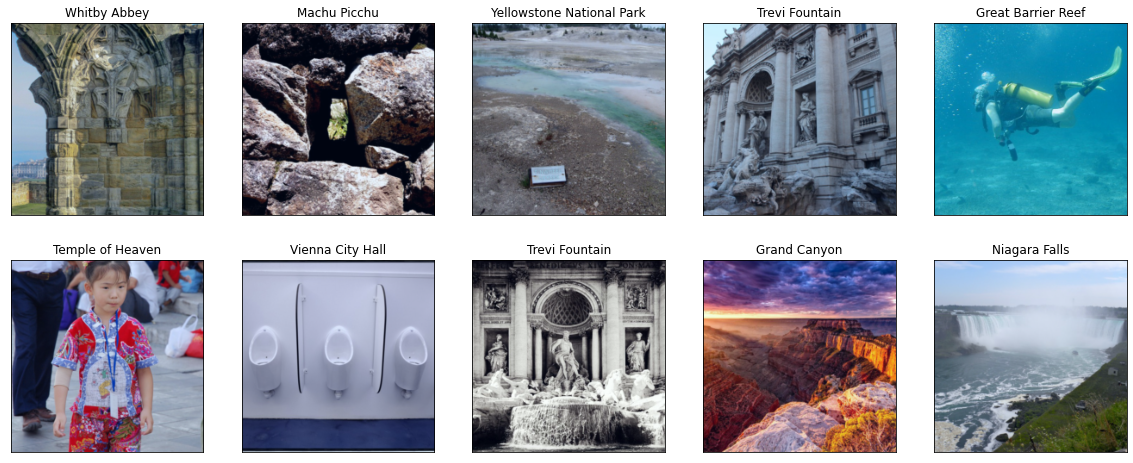

In [15]:
fig = plt.figure(figsize=(20, 8))
for idx in np.arange(10):
    ax = fig.add_subplot(2, int(10/2), idx+1, xticks=[], yticks=[])
    min_val = np.min(images[idx])
    max_val = np.max(images[idx])
    img_scaled = (images[idx] - min_val) / (max_val - min_val)
    plt.imshow(np.transpose(img_scaled, (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

### Initialize use_cuda variable

In [16]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [17]:
import torch.nn as nn
## TODO: select loss function
criterion_scratch = criterion = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.8)
    return optimizer

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [18]:
# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()

#         # convolutional layer (sees 32x32x3 image tensor)
#         self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
#         # convolutional layer (sees 16x16x16 tensor)
#         self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
#         # convolutional layer (sees 8x8x32 tensor)
#         self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
#         # max pooling layer
#         self.pool = nn.MaxPool2d(2, 2)
#         # linear layer (64 * 4 * 4 -> 500)
#         self.fc1 = nn.Linear(50176, 512)
#         # linear layer (500 -> 10)
#         self.fc2 = nn.Linear(512, num_classes)
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc1 = nn.Linear(64*28*28, 512)
        self.fc2 = nn.Linear(512, 50)
        
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)
            
    def forward(self, x):

#         # add sequence of convolutional and max pooling layers
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.pool(F.relu(self.conv3(x)))
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        # flatten image input
#         print(x.shape)
        x = x.view(x.size(0), -1)

        # add dropout layer
        x = self.dropout(x)

        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))

        # add dropout layer
        x = self.dropout(x)

        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)

        return x      

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

# print the model
summary(model_scratch, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
              ReLU-2         [-1, 16, 224, 224]               0
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
              ReLU-5         [-1, 32, 112, 112]               0
         MaxPool2d-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          18,496
              ReLU-8           [-1, 64, 56, 56]               0
         MaxPool2d-9           [-1, 64, 28, 28]               0
          Dropout-10                [-1, 50176]               0
           Linear-11                  [-1, 512]      25,690,624
          Dropout-12                  [-1, 512]               0
           Linear-13                   [-1, 50]          25,650
Total params: 25,739,858
Trainable para

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  

There are three convolution layers followed by a fully connected layer.

Each convolution layer has a Conv2d with kernal_size = 3 and padding = 1. The input channels are 3, 16, 32 in sequence, and the corresponding output channels are 16, 32, 64. They followed by 2*2 Max pooling layer. Then a dropout layer (p = 0.25) and the last fully connected linear layer.

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [19]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    total_used_time = 0
    if use_cuda:
        print("Use_cuda: ",use_cuda," -> ", torch.cuda.get_device_name(0))
        print('Memory Usage:')
        print('\tAllocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        print('\tCached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    for epoch in range(1, n_epochs+1):
        start = time()
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()*data.size(0)
#             train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
           # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            
        train_loss = train_loss/len(train_loader)
        valid_loss = valid_loss/len(valid_loader)
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min :
            print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss        
        end = time()
        used_time = (end - start)/60
        total_used_time += used_time
        print('Epoch {} used time :{:.6f} min, total used time:{:.3f} min'.format(
            epoch, used_time, total_used_time))
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [20]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = (1.0/np.sqrt(n))
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)
    
#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Use_cuda:  True  ->  NVIDIA GeForce RTX 3070 Ti
Memory Usage:
	Allocated: 0.1 GB
	Cached:    0.1 GB
Epoch: 1 	Training Loss: 123.273611 	Validation Loss: 130.353088
Validation loss decreased (inf --> 130.353088). Saving model ...
Epoch 1 used time :0.267726 min, total used time:0.268 min
Epoch: 2 	Training Loss: 122.687061 	Validation Loss: 115.741564
Validation loss decreased (130.353088 --> 115.741564). Saving model ...
Epoch 2 used time :0.192571 min, total used time:0.460 min
Epoch: 3 	Training Loss: 117.446323 	Validation Loss: 111.239083
Validation loss decreased (115.741564 --> 111.239083). Saving model ...
Epoch 3 used time :0.197248 min, total used time:0.658 min
Epoch: 4 	Training Loss: 108.993451 	Validation Loss: 107.097896
Validation loss decreased (111.239083 --> 107.097896). Saving model ...
Epoch 4 used time :0.196324 min, total used time:0.854 min
Epoch: 5 	Training Loss: 105.958689 	Validation Loss: 102.847302
Validation loss decreased (107.097896 --> 102.847302). Sav

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [21]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 30

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()
    
# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Use_cuda:  True  ->  NVIDIA GeForce RTX 3070 Ti
Memory Usage:
	Allocated: 0.2 GB
	Cached:    1.0 GB
Epoch: 1 	Training Loss: 122.791285 	Validation Loss: 120.555427
Validation loss decreased (inf --> 120.555427). Saving model ...
Epoch 1 used time :0.196723 min, total used time:0.197 min
Epoch: 2 	Training Loss: 119.853551 	Validation Loss: 118.275322
Validation loss decreased (120.555427 --> 118.275322). Saving model ...
Epoch 2 used time :0.192045 min, total used time:0.389 min
Epoch: 3 	Training Loss: 115.457086 	Validation Loss: 113.727329
Validation loss decreased (118.275322 --> 113.727329). Saving model ...
Epoch 3 used time :0.196720 min, total used time:0.585 min
Epoch: 4 	Training Loss: 112.851549 	Validation Loss: 109.889510
Validation loss decreased (113.727329 --> 109.889510). Saving model ...
Epoch 4 used time :0.191695 min, total used time:0.777 min
Epoch: 5 	Training Loss: 111.608746 	Validation Loss: 107.457301
Validation loss decreased (109.889510 --> 107.457301). Sav

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [22]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [23]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.039046


Test Accuracy: 24% (312/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [24]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

loaders_transfer = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [25]:
## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()

def get_optimizer_transfer(model):
    ## TODO: select and return an optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.8)
    return optimizer

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [26]:
## TODO: Specify model architecture

model_transfer = models.vgg16(pretrained=True)

# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False
    
n_inputs = model_transfer.classifier[6].in_features

# add last linear layer (n_inputs -> len(classes))
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))

model_transfer.classifier[6] = last_layer

#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

# print the model
summary(model_scratch, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
              ReLU-2         [-1, 16, 224, 224]               0
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
              ReLU-5         [-1, 32, 112, 112]               0
         MaxPool2d-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          18,496
              ReLU-8           [-1, 64, 56, 56]               0
         MaxPool2d-9           [-1, 64, 28, 28]               0
          Dropout-10                [-1, 50176]               0
           Linear-11                  [-1, 512]      25,690,624
          Dropout-12                  [-1, 512]               0
           Linear-13                   [-1, 50]          25,650
Total params: 25,739,858
Trainable para

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  

Once we have the pre-trained feature extractor, we just need to add to the final, fully-connected classifier layers. I used the vgg16 model. The training of all feature layers were fozen and only the classifier layer was trained. The last linear layer was modified to the right number of output features.

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [27]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
n_epochs = 30
model_transfer =train(n_epochs, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer), 
                      criterion_transfer, use_cuda, 'model_transfer.pt')

#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Use_cuda:  True  ->  NVIDIA GeForce RTX 3070 Ti
Memory Usage:
	Allocated: 0.7 GB
	Cached:    1.4 GB
Epoch: 1 	Training Loss: 56.861724 	Validation Loss: 38.275956
Validation loss decreased (inf --> 38.275956). Saving model ...
Epoch 1 used time :0.320683 min, total used time:0.321 min
Epoch: 2 	Training Loss: 26.513297 	Validation Loss: 35.908171
Validation loss decreased (38.275956 --> 35.908171). Saving model ...
Epoch 2 used time :0.312038 min, total used time:0.633 min
Epoch: 3 	Training Loss: 16.132696 	Validation Loss: 31.704198
Validation loss decreased (35.908171 --> 31.704198). Saving model ...
Epoch 3 used time :0.325105 min, total used time:0.958 min
Epoch: 4 	Training Loss: 9.315322 	Validation Loss: 31.889361
Epoch 4 used time :0.268163 min, total used time:1.226 min
Epoch: 5 	Training Loss: 6.204294 	Validation Loss: 33.629933
Epoch 5 used time :0.263376 min, total used time:1.489 min
Epoch: 6 	Training Loss: 4.125595 	Validation Loss: 33.558153
Epoch 6 used time :0.26365

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [28]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.863976


Test Accuracy: 76% (961/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [29]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    img = Image.open(img_path)
    img_transforms = transforms.Compose([transforms.Resize(224),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])
    transf_img = img_transforms(img).unsqueeze(0)
    if use_cuda:
        transf_img = transf_img.cuda()
        
    model_transfer.load_state_dict(torch.load('model_transfer.pt'))
#   set the model in evaluation mode before performing inference
    model_transfer.eval()
    pred_img = model_transfer(transf_img)
#     print(pred_img)
    values, indices = torch.topk(pred_img,k)
#     print(values,indices)
    predictions = [classes[i] for i in indices[0].tolist()]
    return predictions

# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['Golden Gate Bridge',
 'Sydney Harbour Bridge',
 'Forth Bridge',
 'Niagara Falls',
 'Dead Sea']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

Actual Label: Golden Gate Bridge
Predicted Label: Golden Gate Bridge


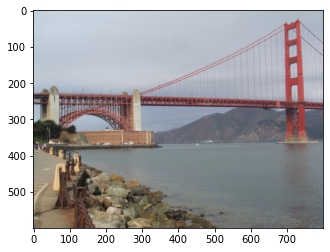

In [30]:
import seaborn as sns
def suggest_locations(img_path):
#     
    
    # get landmark predictions
    landmarks  = predict_landmarks(img_path, 3)
    print(f"Predicted Label: {landmarks[0]}")
    ## TODO: display image and display landmark predictions
    img = Image.open(img_path).convert('RGB')
#     plt.figure(figsize = (6,10))
#     ax = plt.subplot(2,1,1)
    plt.imshow(img)
    plt.show()
#     plt.subplot(2,1,2)
#     sns.barplot(x=confidence, y=landmarks, color=sns.color_palette()[0]);
#     plt.show()

# test on a sample image
sam_img = 'images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg'
print(f"Actual Label: {sam_img.split('/')[2][3:].replace('_',' ')}")

suggest_locations(sam_img)

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

The output is worse than I expected.
Three possible points of improvement:
1. Increase the number of epoch and make loss as small as possible.
2. Try different loss function.
3. Try to use more convolution layers and different learning rate.

Actual Label: National Museum of Singapore
Predicted Label: Monumento a la Revolucion


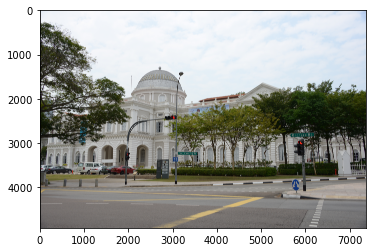

Actual Label: Resorts World Sentosa
Predicted Label: Mount Rushmore National Memorial


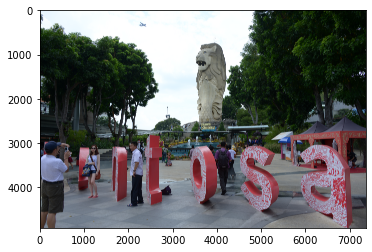

Actual Label: Sentosa
Predicted Label: Petronas Towers


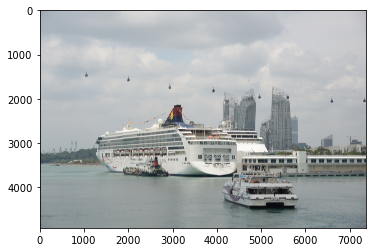

Actual Label: The Imperial Palace
Predicted Label: Temple of Heaven


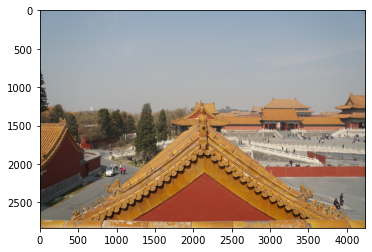

In [31]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.
import glob
test_dir='test_images/*'
for test_img in glob.glob(test_dir):
    test_img_name = test_img.split('\\')[1][:-4]
    print(f"Actual Label: {test_img_name.replace('_',' ')}")
    suggest_locations(test_img)